In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Author: goncalo.abreu@jungle.ai

# Problems when predicting Time Series

Predicing time series is a very specific machine learning problem. This notebook intends to be a very small example on what that problem is, and one way to deal with it (differencing).

## Generating a non-stationary Signal

In [151]:
Fs = 1000
f = 20
sample = Fs

In [213]:
rng = pd.date_range('1/1/2017', periods=sample, freq='1Min')

In [214]:
var = np.arange(sample) * 0.003

### A variant frequency sine wave

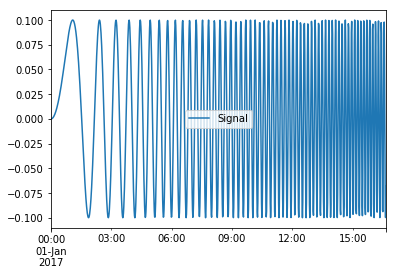

In [215]:
x = np.arange(sample)
ts = pd.Series(0.1*np.sin(2* var * np.pi * f * x / Fs), index=rng).to_frame(name='Signal')
ts.plot()
plt.show()

### Two lines with different cliffs 

In [216]:
import matplotlib.pyplot as plt
t = np.linspace(0, 1, Fs)
linear_signal_1 = 0.5*t
linear_signal_2 = 3*t-1.24

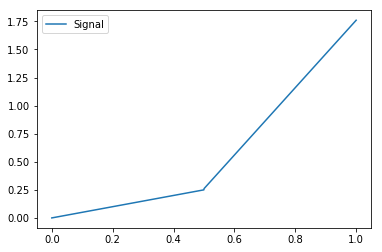

In [217]:
result = np.hstack([linear_signal_1[:int(len(linear_signal_1)/2)],linear_signal_2[int(len(linear_signal_1)/2):]])
plt.plot(t, result, label='Signal')
plt.legend()
plt.show()

### Sum both signals and add some random noise with a Gaussian Mixture

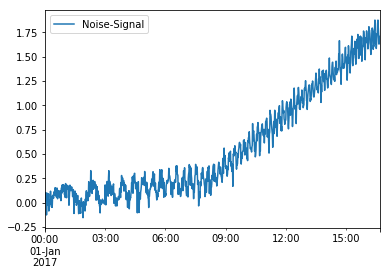

In [218]:
def probability_transform(x):
    if np.random.random() > 0.5:
        return x + np.random.normal(0.01,0.03)
    else:
        return x + np.random.normal(-0.01,0.07)
    return x
    
ts['Noise-Signal'] = ts.Signal.apply(probability_transform) + result
ts[['Noise-Signal']].plot()
plt.show()

## Build a model

This is supposed to be a one step ahead predictor, i.e. 


$X_{t}=\alpha_{1}X_{t-1}+\alpha_{2}X_{t-2}+ ... +\alpha_{n}X_{t-n}$

with,

$y=X_{t}$

In [219]:
def build_arma(window_size,df,target,columns,fillna=0):
    X = df[columns].copy()
    for i in range(1,window_size+1):
        for c in columns:
            X[c+'_lagged-'+str(i)] = df[c].shift(i).fillna(fillna)
    y = df[[target]].shift(-1).fillna(fillna)
    return X, y
X, y = build_arma(10,ts,'Noise-Signal',['Noise-Signal'])

In [220]:
X.head()

,Noise-Signal,Noise-Signal_lagged-1,Noise-Signal_lagged-2,Noise-Signal_lagged-3,Noise-Signal_lagged-4,Noise-Signal_lagged-5,Noise-Signal_lagged-6,Noise-Signal_lagged-7,Noise-Signal_lagged-8,Noise-Signal_lagged-9,Noise-Signal_lagged-10
2017-01-01 00:00:00,0.024085,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:01:00,0.024739,0.024085,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:02:00,0.018886,0.024739,0.024085,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:03:00,0.100852,0.018886,0.024739,0.024085,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 00:04:00,0.017735,0.100852,0.018886,0.024739,0.024085,0.0,0.0,0.0,0.0,0.0,0.0


### Make training and testing sets, and use only a little part of the data for training

In [221]:
split='2017-01-01 03:00'
X_train = X.loc[:split]
X_test  = X.loc[split:]
y_train = y.loc[:split]
y_test  = y.loc[split:]

### Linear Regression

In [222]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.0001)
clf.fit(X_train, y_train)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [223]:
to_see = ts[['Noise-Signal']].copy()
to_see['preds'] = clf.predict(X)

In [224]:
to_see.head()

,Noise-Signal,preds
2017-01-01 00:00:00,0.024085,0.018405
2017-01-01 00:01:00,0.024739,0.021187
2017-01-01 00:02:00,0.018886,0.022160
2017-01-01 00:03:00,0.100852,0.048555
2017-01-01 00:04:00,0.017735,0.034438


### Plot predictions

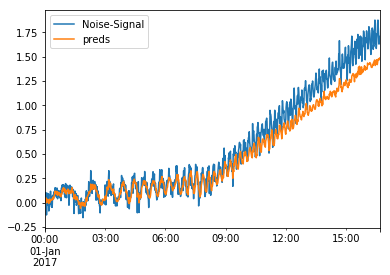

In [225]:
to_see.plot()
plt.show()

In [226]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(to_see['Noise-Signal'],to_see['preds'])
print('MSE = '+str(round(error,5)))

MSE = 0.01984


### Non Linear Model

In [227]:
from xgboost import XGBRegressor
clf = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1)
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [228]:
to_see = ts[['Noise-Signal']].copy()
to_see['preds'] = clf.predict(X)

In [229]:
to_see.head()

,Noise-Signal,preds
2017-01-01 00:00:00,0.024085,0.019007
2017-01-01 00:01:00,0.024739,0.021868
2017-01-01 00:02:00,0.018886,0.029677
2017-01-01 00:03:00,0.100852,0.030692
2017-01-01 00:04:00,0.017735,-0.042515


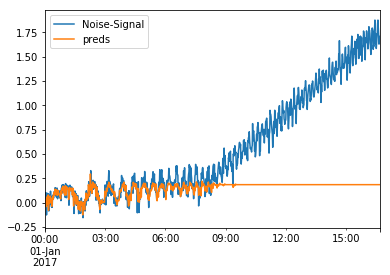

In [230]:
to_see.plot()
plt.show()

In [231]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(to_see['Noise-Signal'],to_see['preds'])
print('MSE = '+str(round(error,5)))

MSE = 0.44197


### Neural Networks

In [232]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(100, ), random_state=1)
clf.fit(X_train, y_train)

/home/abriosi/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [233]:
to_see = ts[['Noise-Signal']].copy()
to_see['preds'] = clf.predict(X)

In [234]:
to_see.head()

,Noise-Signal,preds
2017-01-01 00:00:00,0.024085,0.021438
2017-01-01 00:01:00,0.024739,0.019845
2017-01-01 00:02:00,0.018886,0.023816
2017-01-01 00:03:00,0.100852,0.036970
2017-01-01 00:04:00,0.017735,-0.000745


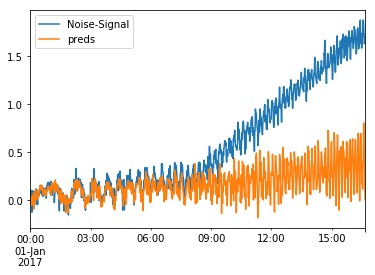

In [235]:
to_see.plot()
plt.show()

In [236]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(to_see['Noise-Signal'],to_see['preds'])
print('MSE = '+str(round(error,5)))

MSE = 0.3702


# Analyse Stationarity

One of the ways to analyse the stationarity of a signal is to plot its autocorrelation

### Signal is not stationary

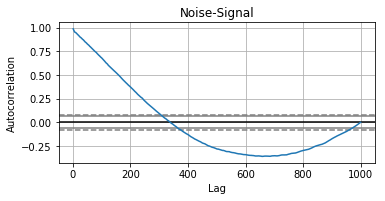

In [237]:
from pandas.plotting import autocorrelation_plot
i=1
plt.figure(figsize=(10,5))
for c in ts[['Noise-Signal']].columns:
    fig = plt.subplot(2, 2, i)
    autocorrelation_plot(ts[c],ax=fig.axes)
    plt.title(c)
    i+=1
plt.tight_layout()
plt.show()

### Apply differencing
Instead of modeling the signal directly we are going to model the variations between time periods

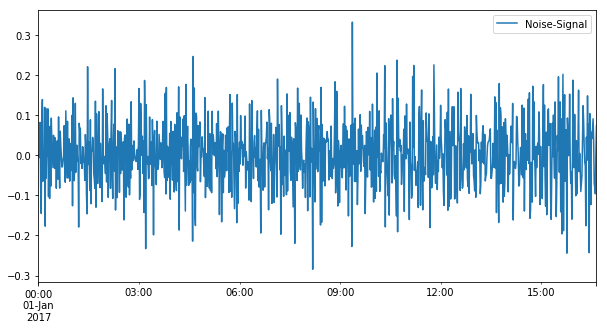

In [258]:
diff = ts[['Noise-Signal']].diff(1)
diff.plot(**{'figsize':(10,5)})
plt.show()

### The differenced signal appears to be stationary

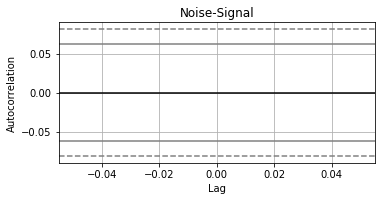

In [259]:
from pandas.plotting import autocorrelation_plot
i=1
plt.figure(figsize=(10,5))
for c in diff.columns:
    fig = plt.subplot(2, 2, i)
    autocorrelation_plot(diff[c],ax=fig.axes)
    plt.title(c)
    i+=1
plt.tight_layout()
plt.show()

### Linear Model

In [260]:
X, y = build_arma(10,diff,'Noise-Signal',['Noise-Signal'])

In [261]:
X = X.fillna(0)
y = y.fillna(0)

In [262]:
X_train = X.loc[:split]
X_test  = X.loc[split:]
y_train = y.loc[:split]
y_test  = y.loc[split:]

In [263]:
clf = Ridge(alpha=0.1)
clf.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [264]:
to_see = diff[['Noise-Signal']].copy()
to_see['preds'] = clf.predict(X)

In [265]:
to_see.head()

,Noise-Signal,preds
2017-01-01 00:00:00,NaN,0.000647
2017-01-01 00:01:00,0.000654,0.000295
2017-01-01 00:02:00,-0.005853,0.003563
2017-01-01 00:03:00,0.081965,-0.041564
2017-01-01 00:04:00,-0.083116,0.016735


### Signal variation predictions

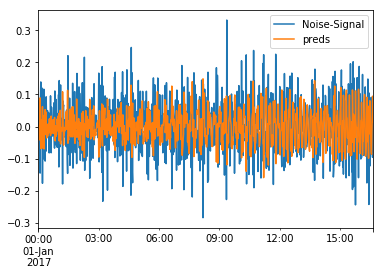

In [246]:
to_see.plot()
plt.show()

In [247]:
to_see['Noise-Signal'] = ts[['Noise-Signal']].copy()
to_see['Noise-Signal_undiff'] = ts[['Noise-Signal']].shift(1).copy()
to_see.head()

,Noise-Signal,preds,Noise-Signal_undiff
2017-01-01 00:00:00,0.024085,0.000647,NaN
2017-01-01 00:01:00,0.024739,0.000295,0.024085
2017-01-01 00:02:00,0.018886,0.003563,0.024739
2017-01-01 00:03:00,0.100852,-0.041564,0.018886
2017-01-01 00:04:00,0.017735,0.016735,0.100852


In [248]:
to_see['reconstructed'] = to_see['Noise-Signal_undiff'] + to_see['preds']
to_see.head()

,Noise-Signal,preds,Noise-Signal_undiff,reconstructed
2017-01-01 00:00:00,0.024085,0.000647,NaN,NaN
2017-01-01 00:01:00,0.024739,0.000295,0.024085,0.024380
2017-01-01 00:02:00,0.018886,0.003563,0.024739,0.028302
2017-01-01 00:03:00,0.100852,-0.041564,0.018886,-0.022678
2017-01-01 00:04:00,0.017735,0.016735,0.100852,0.117587


### Reconstructed signal

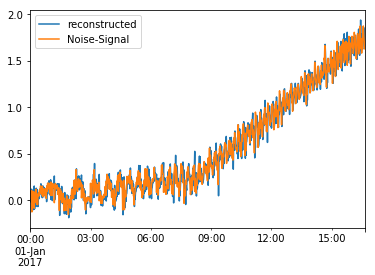

In [249]:
to_see[['reconstructed','Noise-Signal']].plot()
plt.show()

In [250]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(to_see['Noise-Signal'][1:],to_see['reconstructed'][1:])
print('MSE = '+str(round(error,5)))

MSE = 0.01505


### Non Linear Model

In [251]:
from xgboost import XGBRegressor
clf = XGBRegressor(n_estimators=90,max_depth=1,learning_rate=0.1)
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=90, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Signal variation predictions

In [252]:
to_see = diff[['Noise-Signal']].copy()
to_see['preds'] = clf.predict(X)

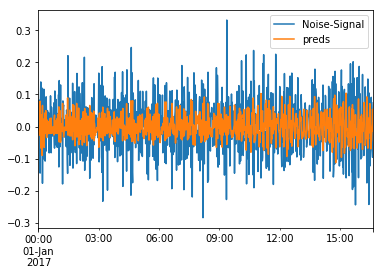

In [253]:
### Signal variation predictionsto_see.plot()
plt.show()

In [254]:
to_see['Noise-Signal'] = ts[['Noise-Signal']].copy()
to_see['Noise-Signal_undiff'] = ts[['Noise-Signal']].shift(1).copy()
to_see.head()

,Noise-Signal,preds,Noise-Signal_undiff
2017-01-01 00:00:00,0.024085,-0.010607,NaN
2017-01-01 00:01:00,0.024739,-0.010607,0.024085
2017-01-01 00:02:00,0.018886,-0.010607,0.024739
2017-01-01 00:03:00,0.100852,-0.026716,0.018886
2017-01-01 00:04:00,0.017735,0.016081,0.100852


In [255]:
to_see['reconstructed'] = to_see['Noise-Signal_undiff'] + to_see['preds']
to_see.head()

,Noise-Signal,preds,Noise-Signal_undiff,reconstructed
2017-01-01 00:00:00,0.024085,-0.010607,NaN,NaN
2017-01-01 00:01:00,0.024739,-0.010607,0.024085,0.013478
2017-01-01 00:02:00,0.018886,-0.010607,0.024739,0.014132
2017-01-01 00:03:00,0.100852,-0.026716,0.018886,-0.007830
2017-01-01 00:04:00,0.017735,0.016081,0.100852,0.116932


### Reconstructed signal

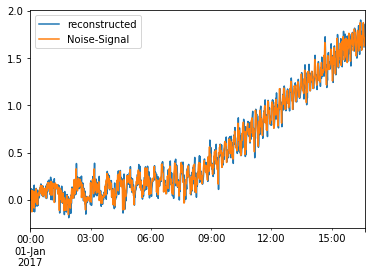

In [256]:
to_see[['reconstructed','Noise-Signal']].plot()
plt.show()

In [257]:
from sklearn.metrics import mean_absolute_error
error = mean_squared_error(to_see['Noise-Signal'][1:],to_see['reconstructed'][1:])
print('MSE = '+str(round(error,5)))

MSE = 0.01271
